In [1]:
import import_ipynb
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

# 数据加载

In [3]:
mnist_train = datasets.MNIST(
    './data/', 
    train=True, 
    transform=transforms.Compose([
        transforms.ToTensor()
    ]), 
    download=True
)
mnist_train = DataLoader(mnist_train, batch_size=32, shuffle=True)

In [4]:
mnist_test = datasets.MNIST(
    './data/', 
    train=False, 
    transform=transforms.Compose([
        transforms.ToTensor()
    ]), 
    download=True
)
mnist_test = DataLoader(mnist_test, batch_size=32, shuffle=True)

In [5]:
# x, _ = iter(mnist_train).next()
x, _ = next(iter(mnist_train))
print('x:', x.shape)

x: torch.Size([32, 1, 28, 28])


# 模型定义

In [6]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # [b, 784] => [b, 20]
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 20),
            nn.ReLU()
        )
        # [b, 20] => [b, 784]
        self.decoder = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
    def encode(self, x, batchsz):
        # flatten
        x = x.view(batchsz, 784)
        # encoder
        return self.encoder(x)
    def decode(self, x, batchsz):
        # decoder
        x = self.decoder(x)
        # reshape
        x = x.view(batchsz, 1, 28, 28)
        return x
    def forward(self, x):
        """
        :param x: [b, 1, 28, 28]
        :return: [b, 1, 28, 28]
        """
        batchsz = x.size(0)
        x = self.encode(x, batchsz)
        x = self.decode(x, batchsz)
        return x

# 模型训练

In [7]:
def train(model, mnist_train, epoch, device):
    # MSE损失
    criteon = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for batchidx, (x, _) in enumerate(mnist_train):
        # [b, 1, 28, 28]
        x = x.to(device)
        x_hat = model(x)
        loss = criteon(x_hat, x)
        if batchidx % 100 == 0:
            print('epoch: ', epoch, 'batchidx: ', batchidx, ', loss: ', loss.item())
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch: ', epoch, ', loss: ', loss.item())

# 图像显示

In [8]:
def show_images_list(images_list):
    print('images list size: ', len(images_list))
    # 每列显示的图像数量
    n_cols = 2
    # 每行显示的图像数量
    n_rows = len(images_list) // n_cols
    print('n_cols: ', n_cols)
    print('n_rows: ', n_rows)
    fig, axes = plt.subplots(n_rows, n_cols)
    for i, ax in enumerate(axes.flat):
        grid = torchvision.utils.make_grid(images_list[i])
        grid = grid.numpy()
        grid = np.transpose(grid, (1, 2, 0))
        ax.imshow(grid, cmap='gray')
        ax.set(xticklabels=[], yticklabels=[], title=f'Image {i+1}')
    plt.tight_layout()
    plt.show()

In [9]:
def main():
    device = torch.device('cuda')
    # 自编码器
    model = AE().to(device)
    print(model)
    images_list = []
    print('len(mnist_train): ', len(mnist_train))
    print('len(mnist_test): ', len(mnist_test))
    # for epoch in range(1000):
    for epoch in range(2):
        train(model, mnist_train, epoch, device)
        # x, _ = iter(mnist_test).next()
        x, _ = next(iter(mnist_test))
        x = x.to(device)
        with torch.no_grad():
            # 生成图像
            x_hat = model(x)
            images_list.append(x_hat.detach().cpu())
    show_images_list(images_list)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=20, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
len(mnist_train):  1875
len(mnist_test):  313
epoch:  0 batchidx:  0 , loss:  0.23067711293697357
epoch:  0 batchidx:  100 , loss:  0.06873586028814316
epoch:  0 batchidx:  200 , loss:  0.05661095306277275
epoch:  0 batchidx:  300 , loss:  0.0526006855070591
epoch:  0 batchidx:  400 , loss:  0.042119693011045456
epoch:  0 batchidx:  500 , loss:  0.035922128707170486
epoch:  0 batchidx:  600 , loss:  0.03824916109442711
epoch:  0 batchidx:  700 , loss:  0.029178312048

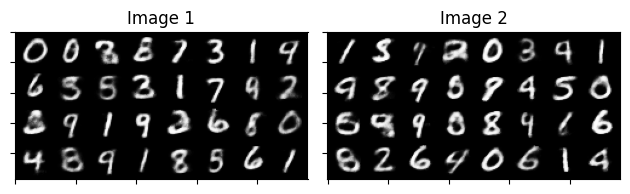

In [10]:
if __name__ == '__main__':
    main()